Copyright 2022 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

     https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

# Adversarial training


[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/google/jaxopt/blob/main/docs/notebooks/deep_learning/adversarial_training.ipynb)


The following code trains a convolutional neural network (CNN) to be robust
with respect to the projected gradient descent (PGD) method.

The Projected Gradient Descent Method (PGD) is a simple yet effective method to
generate adversarial images. At each iteration, it adds a small perturbation
in the direction of the sign of the gradient with respect to the input followed
by a projection onto the infinity ball. The gradient sign ensures this
perturbation locally maximizes the objective, while the projection ensures this
perturbation stays on the boundary of the infinity ball.

## References

  Goodfellow, Ian J., Jonathon Shlens, and Christian Szegedy. "Explaining
  and harnessing adversarial examples.", https://arxiv.org/abs/1412.6572

  Madry, Aleksander, et al. "Towards deep learning models resistant to
  adversarial attacks.", https://arxiv.org/pdf/1706.06083.pdf

In [2]:
%%capture
%pip install jaxopt flax

In [3]:
import datetime
import collections

# activate TPUs if available
try:
    import jax.tools.colab_tpu
    jax.tools.colab_tpu.setup_tpu()
except (KeyError, RuntimeError):
    print("TPU not found, continuing without it.")
from flax import linen as nn
import jax
from jax import numpy as jnp
from jaxopt import loss
from jaxopt import OptaxSolver
from jaxopt import tree_util

from matplotlib import pyplot as plt
plt.rcParams.update({'font.size': 22})

import optax
import tensorflow as tf
import tensorflow_datasets as tfds

Show on which platform JAX is running. The code below should take around 3 min to run on GPU but might take longer on CPUs.

In [3]:
print("JAX running on", jax.devices()[0].platform.upper())

JAX running on GPU


In [4]:
Flags = collections.namedtuple(
    "Flags",
    [
        "l2reg",  # amount of L2 regularization in the objective
        "learning_rate",  # learning rate for the Adam optimizer
        "epochs",  # number of passes over the dataset
        "dataset",  # one of "mnist", "kmnist", "emnist", "fashion_mnist", "cifar10", "cifar100"
        "epsilon", # Adversarial perturbations lie within the infinity-ball of radius epsilon.
        "train_batch_size",  # Batch size at train time
        "test_batch_size"  # Batch size at test time
    ])

FLAGS = Flags(
    l2reg=0.0001,
    learning_rate=0.001,
    epochs=10,
    dataset="mnist",
    epsilon=0.01,
    train_batch_size=128,
    test_batch_size=128)

In [5]:
def load_dataset(split, *, is_training, batch_size):
  """Load dataset using tensorflow_datasets."""
  version = 3
  ds, ds_info = tfds.load(
      f"{FLAGS.dataset}:{version}.*.*",
      as_supervised=True,  # remove useless keys
      split=split,
      with_info=True)
  ds = ds.cache().repeat()
  if is_training:
    ds = ds.shuffle(10 * batch_size, seed=0)
  ds = ds.batch(batch_size)
  return iter(tfds.as_numpy(ds)), ds_info


class CNN(nn.Module):
  """A simple CNN model."""
  num_classes: int

  @nn.compact
  def __call__(self, x):
    x = nn.Conv(features=32, kernel_size=(3, 3))(x)
    x = nn.relu(x)
    x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
    x = nn.Conv(features=64, kernel_size=(3, 3))(x)
    x = nn.relu(x)
    x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
    x = x.reshape((x.shape[0], -1))  # flatten
    x = nn.Dense(features=256)(x)
    x = nn.relu(x)
    x = nn.Dense(features=self.num_classes)(x)
    return x

In [6]:
# Hide any GPUs from TensorFlow. Otherwise TF might reserve memory and make
# it unavailable to JAX.
tf.config.experimental.set_visible_devices([], "GPU")
train_ds, ds_info = load_dataset("train", is_training=True,
                                 batch_size=FLAGS.train_batch_size)
test_ds, _ = load_dataset("test", is_training=False,
                          batch_size=FLAGS.test_batch_size)
input_shape = (1,) + ds_info.features["image"].shape
num_classes = ds_info.features["label"].num_classes
iter_per_epoch_train = ds_info.splits['train'].num_examples // FLAGS.train_batch_size
iter_per_epoch_test = ds_info.splits['test'].num_examples // FLAGS.test_batch_size


net = CNN(num_classes)

@jax.jit
def accuracy(params, data):
  inputs, labels = data
  logits = net.apply({"params": params}, inputs)
  return jnp.mean(jnp.argmax(logits, axis=-1) == labels)

logistic_loss = jax.vmap(loss.multiclass_logistic_loss)

@jax.jit
def loss_fun(params, l2reg, data):
  """Compute the loss of the network."""
  inputs, labels = data
  x = inputs.astype(jnp.float32)
  logits = net.apply({"params": params}, x)
  sqnorm = tree_util.tree_l2_norm(params, squared=True)
  loss_value = jnp.mean(logistic_loss(labels, logits))
  return loss_value + 0.5 * l2reg * sqnorm

@jax.jit
def pgd_attack(image, label, params, epsilon=0.1, maxiter=10):
  """PGD attack on the L-infinity ball with radius epsilon.

  Args:
    image: array-like, input data for the CNN
    label: integer, class label corresponding to image
    params: tree, parameters of the model to attack
    epsilon: float, radius of the L-infinity ball.
    maxiter: int, number of iterations of this algorithm.

  Returns:
    perturbed_image: Adversarial image on the boundary of the L-infinity ball
      of radius epsilon and centered at image.

  Notes:
    PGD attack is described in (Madry et al. 2017),
    https://arxiv.org/pdf/1706.06083.pdf
  """
  image_perturbation = jnp.zeros_like(image)
  def adversarial_loss(perturbation):
    return loss_fun(params, 0, (image + perturbation, label))

  grad_adversarial = jax.grad(adversarial_loss)
  for _ in range(maxiter):
    # compute gradient of the loss wrt to the image
    sign_grad = jnp.sign(grad_adversarial(image_perturbation))

    # heuristic step-size 2 eps / maxiter
    image_perturbation += (2 * epsilon / maxiter) * sign_grad
    # projection step onto the L-infinity ball centered at image
    image_perturbation = jnp.clip(image_perturbation, - epsilon, epsilon)

  # clip the image to ensure pixels are between 0 and 1
  return jnp.clip(image + image_perturbation, 0, 1)

In [7]:
# Initialize solver and parameters.
solver = OptaxSolver(
    opt=optax.adam(FLAGS.learning_rate),
    fun=loss_fun,
    maxiter=FLAGS.epochs * iter_per_epoch_train)
key = jax.random.PRNGKey(0)
params = net.init(key, jnp.zeros(input_shape))["params"]

state = solver.init_state(params)
start = datetime.datetime.now().replace(microsecond=0)
jitted_update = jax.jit(solver.update)

accuracy_train = []
accuracy_test = []
adversarial_accuracy_train = []
adversarial_accuracy_test = []
for it in range(solver.maxiter):
  # training loop
  images, labels = next(train_ds)
  # convert images to float as attack requires to take gradients wrt to them
  images = images.astype(jnp.float32) / 255

  adversarial_images_train = pgd_attack(
      images, labels, params, epsilon=FLAGS.epsilon)
  # train on adversarial images
  params, state = jitted_update(
      params=params,
      state=state,
      l2reg=FLAGS.l2reg,
      data=(adversarial_images_train, labels))

  # Once per epoch evaluate the model on the train and test sets.
  if state.iter_num % iter_per_epoch_train == iter_per_epoch_train - 1:

    # compute train set accuracy, both on clean and adversarial images
    adversarial_accuracy_train_sample = 0.
    accuracy_train_sample = 0.
    for _ in range(iter_per_epoch_train):
      images, labels = next(train_ds)
      images = images.astype(jnp.float32) / 255
      accuracy_train_sample += jnp.mean(accuracy(params, (images, labels))) / iter_per_epoch_train
      adversarial_images_train = pgd_attack(
        images, labels, params, epsilon=FLAGS.epsilon)
      adversarial_accuracy_train_sample += jnp.mean(
        accuracy(params, (adversarial_images_train, labels))) / iter_per_epoch_train
    accuracy_train.append(accuracy_train_sample)
    adversarial_accuracy_train.append(adversarial_accuracy_train_sample)

    # compute train set accuracy, both on clean and adversarial images
    adversarial_accuracy_test_sample = 0.
    accuracy_test_sample = 0.
    for _ in range(iter_per_epoch_test):
      images, labels = next(test_ds)
      images = images.astype(jnp.float32) / 255
      accuracy_test_sample += jnp.mean(accuracy(params, (images, labels))) / iter_per_epoch_test
      adversarial_images_test = pgd_attack(
        images, labels, params, epsilon=FLAGS.epsilon)
      adversarial_accuracy_test_sample += jnp.mean(
        accuracy(params, (adversarial_images_test, labels))) / iter_per_epoch_test
    accuracy_test.append(accuracy_test_sample)
    adversarial_accuracy_test.append(adversarial_accuracy_test_sample)


    time_elapsed = (datetime.datetime.now().replace(microsecond=0) - start)
    print(f"Epoch {it // iter_per_epoch_train} out of {FLAGS.epochs}")
    print(f"Accuracy on train set: {accuracy_train[-1]:.3f}")
    print(f"Accuracy on test set: {accuracy_test[-1]:.3f}")
    print(
        f"Adversarial accuracy on train set: {adversarial_accuracy_train[-1]:.3f}"
    )
    print(
        f"Adversarial accuracy on test set: {adversarial_accuracy_test[-1]:.3f}"
    )
    print(f"Time elapsed: {time_elapsed}")
    print()

/opt/conda/envs/jaxopt/lib/python3.10/site-packages/jax/_src/tree_util.py:188: FutureWarning: jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() instead as a drop-in replacement.
  warnings.warn('jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() '


Epoch 0 out of 10
Accuracy on train set: 0.982
Accuracy on test set: 0.982
Adversarial accuracy on train set: 0.979
Adversarial accuracy on test set: 0.979
Time elapsed: 0:00:14

Epoch 1 out of 10
Accuracy on train set: 0.987
Accuracy on test set: 0.986
Adversarial accuracy on train set: 0.984
Adversarial accuracy on test set: 0.982
Time elapsed: 0:00:21

Epoch 2 out of 10
Accuracy on train set: 0.989
Accuracy on test set: 0.987
Adversarial accuracy on train set: 0.986
Adversarial accuracy on test set: 0.984
Time elapsed: 0:00:29

Epoch 3 out of 10
Accuracy on train set: 0.992
Accuracy on test set: 0.990
Adversarial accuracy on train set: 0.990
Adversarial accuracy on test set: 0.988
Time elapsed: 0:00:36

Epoch 4 out of 10
Accuracy on train set: 0.994
Accuracy on test set: 0.990
Adversarial accuracy on train set: 0.992
Adversarial accuracy on test set: 0.988
Time elapsed: 0:00:43

Epoch 5 out of 10
Accuracy on train set: 0.994
Accuracy on test set: 0.990
Adversarial accuracy on train 

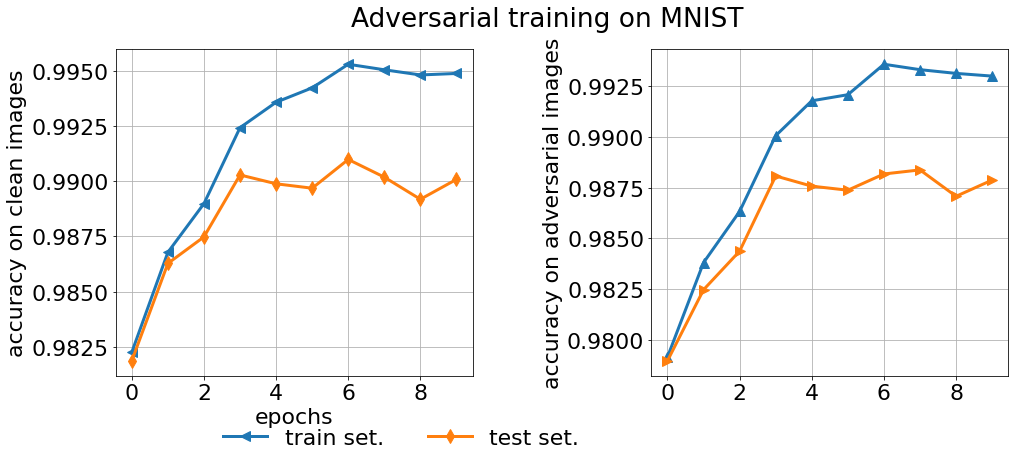

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

plt.suptitle("Adversarial training on " + f"{FLAGS.dataset}".upper())
axes[0].plot(accuracy_train, lw=3, label="train set." , marker='<', markersize=10)
axes[0].plot(accuracy_test, lw=3, label="test set.", marker='d', markersize=10)
axes[0].grid()
axes[0].set_ylabel('accuracy on clean images')

axes[1].plot(
    adversarial_accuracy_train,
    lw=3,
    label="adversarial accuracy on train set.", marker='^', markersize=10)
axes[1].plot(
    adversarial_accuracy_test,
    lw=3,
    label="adversarial accuracy on test set.", marker='>', markersize=10)
axes[1].grid()
axes[0].legend(frameon=False, ncol=2, loc='upper center', bbox_to_anchor=(0.8, -0.1))
axes[0].set_xlabel('epochs')
axes[1].set_ylabel('accuracy on adversarial images')
plt.subplots_adjust( wspace=0.5 )


plt.show()

Find a test set image that is correctly classified but not its adversarial perturbation

In [9]:
def find_adversarial_imgs():
  for _ in range(iter_per_epoch_test):
    images, labels = next(test_ds)
    images = images.astype(jnp.float32) / 255
    logits = net.apply({"params": params}, images)
    labels_clean = jnp.argmax(logits, axis=-1)

    adversarial_images = pgd_attack(
      images, labels, params, epsilon=FLAGS.epsilon)
    labels_adversarial = jnp.argmax(net.apply({"params": params}, adversarial_images), axis=-1)
    idx_misclassified = jnp.where(labels_clean != labels_adversarial)[0]
    if len(idx_misclassified) == 0:
      continue
    else:
      for i in idx_misclassified:
        img_clean = images[i]
        prediction_clean = labels_clean[i]
        if prediction_clean != labels[i]:
          # the clean image predicts the wrong label, skip
          continue
        img_adversarial = adversarial_images[i]
        prediction_adversarial = labels_adversarial[i]
        # we found our image
        return img_clean, prediction_clean, img_adversarial, prediction_adversarial

  raise ValueError("No mismatch between clean and adversarial prediction found")

img_clean, prediction_clean, img_adversarial, prediction_adversarial = \
  find_adversarial_imgs()

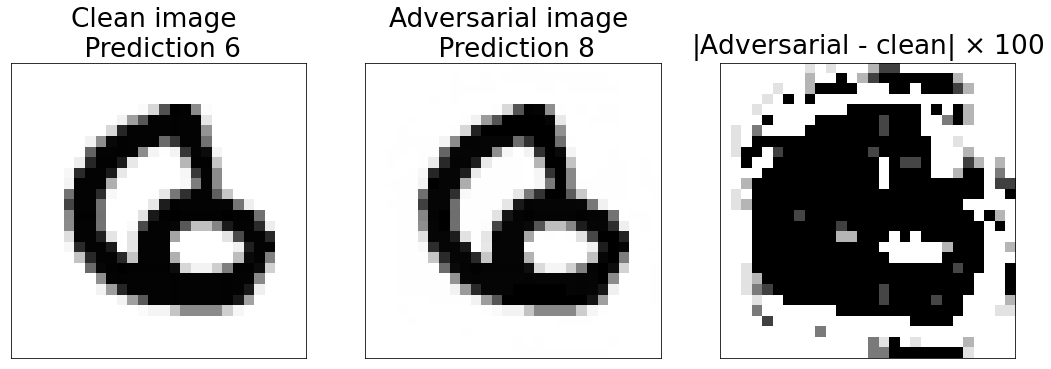

In [10]:
_, axes = plt.subplots(nrows=1, ncols=3, figsize=(6*3, 6))

axes[0].set_title('Clean image \n Prediction %s' % int(prediction_clean))
axes[0].imshow(img_clean, cmap=plt.cm.get_cmap('Greys'), vmax=1, vmin=0)
axes[1].set_title('Adversarial image \n Prediction %s' % prediction_adversarial)
axes[1].imshow(img_adversarial, cmap=plt.cm.get_cmap('Greys'), vmax=1, vmin=0)
axes[2].set_title(r'|Adversarial - clean| $\times$ %.0f' % (1/FLAGS.epsilon))
axes[2].imshow(jnp.abs(img_clean - img_adversarial) / FLAGS.epsilon, cmap=plt.cm.get_cmap('Greys'), vmax=1, vmin=0)
for i in range(3):
    axes[i].set_xticks(())
    axes[i].set_yticks(())
plt.show()